In [1]:
# -*- coding: utf-8 -*-
"""
Model for analysing the effects of coincident peak vs AoB charges

Created on Sun Dec 16 14:46:14 2018

The overall model has 3 components: 
(1) Demand 
(2) Demand-side investment in DG
(3) Supply-side investment in grid-connected generation

This version only looks at allocative efficiency effects (demand with no investment response)

(1) Demand is differentiated by:
(a) type {Mass,DirectConnect}
(b) time of use {Peak,Shoulder,OffPeak,Low}   
(c) region {Backbone node...}
(d) connection (DG, Grid)

"""
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt

In [2]:
path = '/media/usb/notebooks/TPM_CBA_checking/AoB model python files for checking as at 11 April 2019/'
#db = DB(profile="hallj")

In [320]:
#A. DATA import and export
data = pd.read_csv(path + "Data/model_data_bb.csv")
data_gen = pd.read_csv(path + "Data/model_data_bb_gen.csv")
coef_m = pd.read_csv(path + "Data/tou_coef_mass.csv")
coef_i = pd.read_csv(path + "Data/tou_coef_ind.csv")
reg_pop_params = pd.read_csv(path + "Data/reg_pop.csv")
reg_inc_params = pd.read_csv(path + "Data/reg_inc.csv")
tp_rev = pd.read_csv(path + "Data/forecast_revenue.csv")
exist_s = pd.read_csv(path +
                      "Data/aob_existing_asset_benefit_shares_2022_equal.csv")
exist_g = pd.read_csv(path + "Data/existing_gen.csv")
poss_g = pd.read_csv(path + "Data/possible_gen.csv")
major = pd.read_csv(path + "Data/major_capex.csv")
initial_aob = pd.read_csv(path + "Data/Initial_AoB.csv")

# B. PARAMETERS

In [311]:
#   B.1 Number of trading periods
pk_tp = 1600
sh_tp = 3075
off_tp = 12845
mwh = np.array([pk_tp / 2, sh_tp / 2, off_tp / 2])

In [5]:
#   B.2 Base period values - that do not change
yr_0 = 2017 #capacity measurement year ended August 2017
base_year = 2010

In [6]:
#   B.3 Mass market Time of Use (TOU) elasticity/LAAIDS parameters - from data
gamma = np.column_stack(np.array(coef_m[coef_m['type'] == 'gamma']['coef']))
gamma = np.transpose(np.reshape(gamma, (4, 4)))
beta = np.column_stack(np.array(coef_m[coef_m['type'] == 'beta']['coef']))
beta = np.transpose(np.matrix(beta))
dg_c = np.column_stack(np.array(coef_m[coef_m['type'] == 'dg']['coef']))
dg_c

array([[-0.42,  0.65,  0.09,  0.46]])

In [7]:
#   B.4 Large industrials TOU elasticity/LAAIDS parameters - from data
gamma_i = np.column_stack(np.array(coef_i[coef_i['type'] == 'gamma']['coef']))
gamma_i = np.transpose(np.reshape(gamma_i, (4, 4)))
beta_i = np.column_stack(np.array(coef_i[coef_i['type'] == 'beta']['coef']))
beta_i = np.transpose(np.matrix(beta_i))
dg_c_i = np.column_stack(np.array(coef_i[coef_i['type'] == 'dg']['coef']))

In [8]:
#   B.5 Market aggregate price and demand parameters (non TOU)
p_e = -0.11  #Aggregate mass market price (per ICP) elasticity
m_e = 0.11  #Aggregate mass market income (per ICP) elasticity
p_e_i = -0.02  #Aggregate industrial price (per ICP) elasticity
VOLL = 1000  #Value of lost load for calculating consumer surplus
disc = 0.08  #Discount rate
p_disc = 1 / (
    (1 + disc)**(19 / 12))  #Discounting expected interconnection charges

In [304]:
len(locals())

621

In [310]:
%whos

Variable                    Type           Data/Info
----------------------------------------------------
DEM                         matrix         [[1502.0230775]]
NUM                         float64        1475.6590775000002
T                           int            33
VOLL                        int            1000
accnt_aob                   DataFrame          p_yr  m_yr          M<...>n\n[51 rows x 38 columns]
accnt_rcpd                  DataFrame          p_yr  m_yr          M<...>n\n[51 rows x 38 columns]
amd                         float          0.0
amd_share                   float          0.2494411239185635
amd_yr                      int            2017
amdshr                      DataFrame           p_yr  m_yr   bb  typ<...>\n[220 rows x 10 columns]
amdshr_f                    function       <function amdshr_f at 0x7f1e97afbc80>
aob                         bool           False
aob0                        float          0.0
aob1                        float          2462

In [9]:
#   B.6 Dimensions
share_n = 4
ones = np.matrix(np.ones((1, share_n)))
T = 33  #Projections time period
yr_l = list(range(yr_0, yr_0 + T))  #Years for projections
reg_l = [
    "MDN", "OTA", "HLY", "TRK", "WKM", "RDF", "SFD", "BPE", "HAY", "KIK",
    "ISL", "BEN", "ROX", "TWI"
]  # Backbone nodes in model
ind_l = ["OTA", "HLY", "TRK", "RDF", "SFD", "BPE", "ISL",
         "TWI"]  #Nodes with large industrial or direct connect demands
gen_l = [
    "HLY", "TRK", "WKM", "RDF", "SFD", "BPE", "HAY", "KIK", "ISL", "BEN",
    "ROX", "TWI"
]  #Nodes with grid connected generation (excludes Otahuhu gen now closed)
si_nodes = ["KIK", "ISL", "BEN", "ROX", "TWI"]
ni_nodes = ["MDN", "OTA", "HLY", "TRK", "WKM", "RDF", "SFD", "BPE", "HAY"]
ctype_l = [
    1, 2
]  #Consumer types, 1= Mass market, 2=Large industrial or direct connect demand

In [241]:
#   B.7 Initial demand growth parameters, need to add
"""
Need to add (a) node-specific values, (b) shifters for scenarios for
electrification or reductions in growth (c) shifters for one off shocks (Tiwai) 
"""
nz_m_g_mu = 1.01  #Mean income growth rate (1+g), labour market earnings per ICP
nz_m_g_sd = 0.005  #Std deviation of income growth rate (1+g), earnings per ICP
icp_g_mu = 1.01  #Mean ICP growth rate (1+g)
icp_g_sd = 0.005  #Std deviation of ICP growth rate


#XXXCHECK
pot4_mw = 50  #Adding Tiwai fourth potline from 2019 to 2022
pot4_on = 2018  # year after which potline turns on
pot4_off = 2022  # year after which potline turns off
pot4 = np.array([(pk_tp / 2) * pot4_mw, 0, (sh_tp / 2) * pot4_mw,
                 (off_tp / 2) * pot4_mw])

In [11]:
#   B.8 Initial generation cost parameters
#       (a) Parameters
#pg_mu = [89.0,89.0,72.5,58.0] #Mean and standard deviation of generation prices
#pg_sd = [38.0,38.0,27.0,21.0] # 2008 prices
pg_mu = [115.3, 115.3, 91.6,
         72.8]  #2018 dollars: Mean and standard deviation of generation prices
pg_sd = [49.6, 49.6, 34.1, 28.0]


#       (b) Function for generating new generation prices from a
#       log normal distribution Note ideally this would be
#       mutivariate with a covariance matrix, but for simplicity
#       we assume the values are perfectly correlated (i.e. same random seed)
def rand_pg(mu=pg_mu, sd=pg_sd, n=1):
    cases = len(mu)
    out = np.zeros((n, cases))
    rnd_num = random.randint(
        0, 10000
    )  #Set a random seed number to ensure values similar (simpler than multivariate)
    for i in range(cases):
        loc = np.log(mu[i]**2 / np.sqrt(sd[i]**2 + mu[i]**2))
        scale = np.sqrt(np.log(1 + (sd[i]**2 / mu[i]**2)))
        np.random.seed(rnd_num)
        rnd = np.random.lognormal(loc, scale, n)
        out[:, i] = rnd
    return out


#       (c) Function for generating the expected value of generation costs, given a weighed average and std deviation
def ln_exp(mu=pg_mu, sd=pg_sd, n=1):
    cases = len(mu)
    out = np.zeros((n, cases))
    for i in range(cases):
        loc = np.log(mu[i]**2 / np.sqrt(sd[i]**2 + mu[i]**2))
        scale = np.sqrt(np.log(1 + (sd[i]**2 / mu[i]**2)))
        out[:, i] = np.exp(loc + 0.5 * scale)
    return out


#       (d) Assumed cost of DG (sensitivity will add a random draw to test different price levels)
#           and supply elasticity (percentage change in DG if price breached)
dg_lrmc_mu = 250  # lrmc - capital and fixed O&M only, based on network batteries, with input/'fuel' cost calculated in the model
dg_capex = 733000
dg_fixed = 67000
hybrid_arbitrage_discount = 0.225  # To discount arbitrage outside peak demand months
max_dg = 2  # Maximum MW dg/batteries capacity to total peak demand, 2 = 50% of peak met by batteries

#XXXCHECK
dg_mwh = 3225
dg_lrmc_g = 0.93  #Assume a 7% cost reduction
dg_ds = 0.5  #Supply elasticity - implies 1% cost advantage increases DG by 1% but is also decreasing function of pk_mw/(dg_mw+pk_mw)
dg_horizon = 15  #Years factored into the DG investment decision

In [12]:
#   B.9 AOB parameters
r_s = 0.695  #Share of DC + AC IC revenue not recovered via AoB [file aob_existing has the info on IC and DC allocations]
aob_yr = 2022  #Year implemented - for measurement purposes(i.e. m_yr)
aob_tp = [pk_tp, pk_tp, sh_tp, off_tp]

In [13]:
#   B.10 Transpower revenue parameters
roi = 0.06  # A constant return on investment
opex_r = 0.06  # An opex allowance - as a share of RAB
deprn = 0.05  # Constant average depreciation
gror = roi + opex_r + deprn  #Gross rate of return [missing tax?]
ic_s = [
    1.0, 0.0, 0.0, 0.0
]  #Share of trading periods to which RCPD applies, by TOU categories - note assumption that average peak price is what matters
ic_s_mwh = [1.0, 0.0, 1.0,
            1.0]  #Values for application of RCPD to MWh - not applied to DG

In [14]:
# Function for updating RCPD interconnection/transmission charges -
# from expectations to "actuals" based on consumption (price component is forward looking)
def rcpd_ic_update(data, year, tp_rev=tp_rev, rcpd_n=ic_s):
    ac_ic = np.asscalar(
        tp_rev.loc[(tp_rev['m_yr'] == year +
                    2), ['ac_ic']].values)  # Interconnection charge
    q_tou = data.loc[(data['m_yr'] == year + 1),
                     ['pk_q', 'dg_q', 'sh_q',
                      'off_q']]  # Market TOU quantities
    Q_tou = np.array(q_tou.sum())  #Aggregate market quantities by TOU
    Q_ic_tou = np.multiply(
        Q_tou,
        rcpd_n)  #Adjust for shares of charges by TOU - default peak only
    Q_ic = np.sum(Q_ic_tou)
    ic_p_update = np.multiply(np.divide(ac_ic, Q_ic), rcpd_n)
    #Get grid price - ex IC
    px1 = np.array(data.loc[(data['m_yr'] == year +
                             1), ['pk_px', 'dg_px', 'sh_px', 'off_px']])
    #Add new IC price into the calculations
    p_update = np.add(px1, ic_p_update)
    #Add new prices back into dataframe
    data.loc[(data['m_yr'] == year +
              1), ['pk_i', 'dg_i', 'sh_i', 'off_i']] = ic_p_update
    data.loc[(data['m_yr'] == year +
              1), ['pk_p', 'dg_p', 'sh_p', 'off_p']] = p_update
    return data

In [15]:
# Function for updating RCPD revenue per MWh collected by Transpower in each measurement year
# this takes the amount of real revenue to be collected in the year, from forecast/actual revenue
# gets peak demand from the prior year and calculates prices
def rcpd_rev_update(data, year, tp_rev=tp_rev, ic_s=ic_s, rcpd_n=ic_s):
    ac_ic = np.asscalar(
        tp_rev.loc[(tp_rev['m_yr'] == year +
                    1), ['ac_ic']].values)  # Interconnection charge
    q_tou = data.loc[(data['m_yr'] == year),
                     ['pk_q', 'dg_q', 'sh_q',
                      'off_q']]  # Market TOU quantities
    Q_tou = np.array(q_tou.sum())  #Aggregate market quantities by TOU
    Q_ic_tou = np.multiply(
        Q_tou,
        rcpd_n)  #Adjust for shares of charges by TOU - default peak only
    Q_ic = np.sum(Q_ic_tou)
    ic_pr_update = np.divide(ac_ic, Q_ic)  #New price
    return ic_pr_update

# D. PROPOSAL PARAMETERS incl forecast revenue and shares of existing assets

In [16]:
#   D.1 Residual revenue,  calculated from a given year of AOB implementation
tp_rev[
    "resid_rev"] = 0  # Initialise residual revenue series, then get intial value:
rev0 = np.asscalar(
    tp_rev.loc[(tp_rev['m_yr'] == aob_yr), ['totrev']].values) * r_s
unallocated = 160000000
#       Revenue calculated as a function of gror and depreciation
tp_rev.loc[(
    tp_rev['m_yr'] >= aob_yr), ['resid_rev']] = unallocated + np.array([
        gror * (((rev0 - unallocated) / gror) * (1 - deprn)**i)
        for i in range(tp_rev['m_yr'].max() - (aob_yr - 1))
    ])

In [17]:
#   D.2 AOB revenue - pre approvals or major capex                        
tp_rev["aob_rev"]=tp_rev["totrev"]-tp_rev['resid_rev']
tp_rev.loc[(tp_rev['m_yr']<aob_yr),['aob_rev']]=0

In [18]:
#   D.3 Calculate a base capex and approved investment series for AOB - based on revenue and fixed ROR
tp_rev["base_capex"]=0
for i in range(1,len(tp_rev)):
    tp_rev.loc[i, 'base_capex'] = (tp_rev.loc[i, 'totrev']-unallocated) - (((tp_rev.loc[i-1, 'totrev']-unallocated)/gror)*(1-deprn))*gror
tp_rev["major_capex"]=0

# Add unapproved capex - listed and major
tp_rev.major_capex=major.major_capex
tp_rev.ac_ic = tp_rev.ac_ic+major.ac_ic
tp_rev.dc_ic = tp_rev.dc_ic+major.dc_ic
tp_rev.aob_rev=tp_rev.aob_rev+major.totrev
tp_rev.totrev = tp_rev.totrev+major.totrev
tp_rev[['ic_g','dc_g','totrev_g']] = tp_rev[['ac_ic','dc_ic','totrev']].pct_change()+1.0

In [19]:
##  D.4 Calculate AOB initial charges/shares (for load) 
#       based on exist_s e.g. exist_ls (load share of benefits of existing assets)
#       from the 2nd issues paper (not board paper cause those numbers not by location) 
#       Needs to be split between industrials and mass, which we do by LCE shares

#       (i) First find average benefits at stake for each type in each node - i.e. LCE
#           [Creating later functions that calculate lce by choice of all periods]
#lce_hist = data.loc[:,['bb','type','m_yr','pk_q','sh_q','off_q','pk_pt','sh_pt','off_pt']]
#lce_hist['lce']=lce_hist.pk_q*lce_hist.pk_pt+lce_hist.sh_q*lce_hist.sh_pt+lce_hist.off_q*lce_hist.off_pt
#lce_hist.loc[(lce_hist['lce']<0),['lce']]=0 #Get rid of net negative benefits in a year
#lce_node_hist = lce_hist.groupby(['bb', 'type']).agg({'lce': 'sum'})
#lce_shares = lce_node_hist.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
#
##       (ii) Then multiply LCE shares by shares of existing assets
#aob_s0=pd.merge(lce_shares,exist_s,on='bb',how='left')
#aob_s0['aob_s0']=aob_s0['lce']*aob_s0['exist_ls']
#aob_s0['bbtype']=aob_s0['bb']+aob_s0.type.map(str)
#aob_s0['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)
#aob_s0['aob_rev0']=aob_s0['aob_rev0']*aob_s0['aob_s0']
#
##       (iii) Generation values
#exist_s['type']=0
#exist_s['bbtype']=exist_s['bb']+exist_s.type.map(str)
#exist_s['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)
#exist_s['aob_rev0_gen']=exist_s['aob_rev0']*exist_s['exist_gs']
#
#gen_aob_shr = exist_s.exist_gs.sum() # For allocations of AOB revenue in the demand model - if want a fixed amount
gen_aob_adj = 0.3333 #Assume area under generation offer curve that is 0.5 

#       (iv) Create a generic trasnport/lce cost function (returns costs as a positive number)
def lce(data=data,reg="OTA",year=yr_0,ctype=1):
        a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
           (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
        a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
                    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
                    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
        if ctype==0:
            a.loc[(a['lce']>0),['lce']]=0
            b = a.lce.sum()*(-1*gen_aob_adj)
        else:
            a.loc[(a['lce']<0),['lce']]=0
            b = a.lce.sum()
        return b


#lce(data=data_gen,reg="SFD",year=2010,ctype=0)        

#       (v) Lce share function - for load
def lceshr_load(data=data,reg="OTA",yr=yr_0,ctype=1):   
        a = data.loc[data['m_yr']==yr,['pk_q','sh_q','off_q','pk_pt','sh_pt','off_pt']]
        a['lce'] = a.pk_q*a.pk_pt+a.sh_q*a.sh_pt+a.off_q*a.off_pt
        a.loc[(a['lce']<0),['lce']]=0
        b = a.lce.sum()
        c=lce(data,reg=reg,yr=yr,ctype=ctype)
        c[c<0]=0 #Only count positive benefits when calculating shares
        d = np.asscalar(c/b)
        return d

#XXXWriteIntoSpreadshee
#       (v) Lce benefit function 
def lceshr(data=data,data_gen=data_gen,reg="OTA",year=yr_0,ctype=1):
    #All load
        a = data.loc[data['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
        a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
                    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
                    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
        a.loc[(a['lce']<0),['lce']]=0
        b = a.lce.sum()
    #All Generation        
        c = data_gen.loc[data_gen['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]#generation
        c['lce'] = (c.pk_theta*(c.pk_q*(c.pk_s_pt_mu-1)*c.pk_pg)+(1-c.pk_theta)*(c.pk_q*(c.pk_ns_pt_mu-1)*c.pk_pg)+ 
                    c.sh_theta*(c.sh_q*(c.sh_s_pt_mu-1)*c.sh_pg)+(1-c.sh_theta)*(c.sh_q*(c.sh_ns_pt_mu-1)*c.sh_pg)+
                    c.off_theta*(c.off_q*(c.off_s_pt_mu-1)*c.off_pg)+(1-c.off_theta)*(c.off_q*(c.off_ns_pt_mu-1)*c.off_pg))
        c['lce'] = c['lce']*(-1*gen_aob_adj) #Reverse sign and adjust value to account for area under offer curves  
        c.loc[(c['lce']<0),['lce']]=0
        d=c.lce.sum()
        e = d+b
   #Numerator        
        if ctype==0:
            f=lce(data_gen,reg=reg,year=year,ctype=ctype)
        else:
            f=lce(data,reg=reg,year=year,ctype=ctype)
        if f.size==0:
            g=0
        else:
            g = np.asscalar(f/e)
        return g

#for reg in reg_l:  
#    print(lceshr(data=df_aob,data_gen=gen_aob,reg=reg,year=2022,ctype=0))
#

In [20]:
#  D.4 Create an AoB account and a revenue account - for convenience
#       Columns that indicate node + type
cols=['p_yr','m_yr']+[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]+[s + str(0) for s in reg_l]#XXXwhy reg here

# AOB account
initial_aob['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)*initial_aob.aob_s0    
cols=['p_yr','m_yr']+[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]+[s + str(0) for s in reg_l]
aob_accnt=pd.DataFrame(columns=cols)
aob_accnt['m_yr']=tp_rev['m_yr']
aob_accnt['p_yr']=tp_rev['p_yr']
aob_accnt=aob_accnt.fillna(0)
load_cols=[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]
gen_cols = [s + str(0) for s in reg_l]

for i in load_cols:
    #aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=aob_s0.loc[aob_s0['bbtype']==i,['aob_rev0']].values
    aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=initial_aob.loc[initial_aob['bbtype']==i,['aob_rev0']].values
for i in gen_cols:
    #aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=exist_s.loc[exist_s['bbtype']==i,['aob_rev0_gen']].values
    aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=initial_aob.loc[initial_aob['bbtype']==i,['aob_rev0']].values

In [21]:
#   D.5 Initialise an AMD function - allowing for periodic resets 
#   This allocation assumes industrial consumers pay based on Offtake (net) and 
#   mass market pay for load (gross)
def amdshr_f(data=data,window=5,gross=1):
    amd0=data.loc[:,['p_yr','m_yr','bb','type']]
    amd0['Load']=data.pk_q+data.dg_q
    amd0['Offtake']=data.loc[:,['pk_q']]
    amd0['Offtake']=data.loc[:,['pk_q']]
    amd0['AMDvol_t']=np.where(amd0['type']==1, amd0['Load'],amd0['Offtake'])
    amd0['AMDvol']=amd0.groupby(['bb','type']).AMDvol_t.apply(lambda x: x.rolling(window=window).sum()).values
    amd0['AMDvol_tot'] = amd0['AMDvol'].groupby(amd0['m_yr']).transform('sum')
    amd0['AMDshr']=amd0.AMDvol/amd0.AMDvol_tot

    return amd0    

#Set initial value for AMD share
amdshr=amdshr_f()

In [22]:
# D.6 Share of investments for reliability vs economic value
econ_share=1
load_reliab_shr = 20000/(20000+200)

In [23]:
#   D.6 Create a benefit share calculation function

# E. OTHER functions

In [24]:
#   South island mean injection
def simi_f(data_gen=data_gen,window=5,ctype=0):
    simi0=data_gen.loc[:,['p_yr','m_yr','bb','type']]
    simi0['SIMIvol_t']=data_gen.pk_q+data_gen.sh_q+data_gen.off_q
    simi0['SIMIvol_pk_t']=data_gen.pk_q
    simi0['SIMIvol_dg_t']=data_gen.dg_q
    simi0['SIMIvol_sh_t']=data_gen.sh_q
    simi0['SIMIvol_off_t']=data_gen.off_q
    simi0.loc[simi0['bb'].isin(ni_nodes), ['SIMIvol_t','SIMIvol_pk_t','SIMIvol_dg_t','SIMIvol_sh_t','SIMIvol_off_t']] = 0
    simi0['SIMIvol']=simi0.groupby(['bb','type']).SIMIvol_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_pk']=simi0.groupby(['bb','type']).SIMIvol_pk_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_dg']=simi0.groupby(['bb','type']).SIMIvol_dg_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_sh']=simi0.groupby(['bb','type']).SIMIvol_sh_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_off']=simi0.groupby(['bb','type']).SIMIvol_off_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_tot'] = simi0['SIMIvol'].groupby(simi0['m_yr']).transform('sum')
    simi0['SIMIshr']=simi0.SIMIvol/simi0.SIMIvol_tot
    return simi0

In [25]:
def genshr_f(data_gen=data_gen,window=5,year=yr_0):
    gen=data_gen.loc[:,['p_yr','m_yr','bb','pk_q','sh_q','off_q']]
    gen['pk_roll']=gen.groupby(['bb']).pk_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['sh_roll']=gen.groupby(['bb']).sh_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['off_roll']=gen.groupby(['bb']).off_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['pk_tot']=gen.groupby(['m_yr']).pk_roll.transform('sum')
    gen['sh_tot']=gen.groupby(['m_yr']).sh_roll.transform('sum')
    gen['off_tot']=gen.groupby(['m_yr']).off_roll.transform('sum')
    gen['pk_s']=gen.pk_roll/gen.pk_tot
    gen['sh_s']=gen.sh_roll/gen.sh_tot    
    gen['off_s']=gen.off_roll/gen.off_tot
    shares = gen.loc[gen['m_yr']==year,['m_yr','bb','pk_s','sh_s','off_s']]
    return shares

In [316]:
def simi_rev_update(data_gen=data_gen,tp_rev=tp_rev,year=yr_0,window=5):
    dc_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+1),['dc_ic']].values) # DC charge
    simishr=simi_f(data_gen=data_gen,window=5)
    vol = simishr[simishr['m_yr']==year].SIMIvol_tot.mean()/window
    vol_q = simishr.loc[simishr['m_yr']==year,['SIMIvol_pk','SIMIvol_dg','SIMIvol_sh','SIMIvol_off']]/window
    price = dc_ic/vol
    rev_q = vol_q*price
    data_gen.loc[(data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=price
    data_gen.loc[data_gen['bb'].isin(ni_nodes), ['pk_pr','dg_pr','sh_pr','off_pr']] = 0
    data_gen.loc[(data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q.values   
    return data_gen  

In [27]:
# Update AOB revenue invoiced to generators
def gen_aob_update(data=data,data_gen=data_gen,aob_accnt=aob_accnt,reg="BEN",year=yr_0,ctype=0):
                    if (year+1) == aob_yr:
                        aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)
                    else:
                        reliab_shr=genshr_f(data_gen=data_gen,window=5,year=year)
                        reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                                    (reliab_shr['bb']==reg),['pk_s']].values)
                        inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                                            np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
                        inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                                                 reg=reg,year=year,ctype=ctype)) 
                                                 + (1-econ_share)*reliab_shr_bb*(1-load_reliab_shr))
                        d_aob = inv*inv_shr #New investment                   
                        aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
                        aob1 = aob0*(1-deprn)+d_aob
                        #Update AOB account
                        aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1
                    #Calculate revenue
                    q0=np.matrix(data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities
                    #XXXlooks like $/hr
                    if np.sum(q0)==0: #Adjustment for areas where plants close
                        pr1 =  np.matrix([[aob1/(pk_tp/2),0,aob1/(sh_tp/2),aob1/(off_tp/2)]])#Revenue paid per MWh
                        rev_q = np.matrix([[aob1*(pk_tp/(pk_tp+sh_tp+off_tp)),0,aob1*(sh_tp/(pk_tp+sh_tp+off_tp)),aob1*(off_tp/(pk_tp+sh_tp+off_tp))]])
                    else:
                        pr1 = np.matrix(np.repeat(aob1/np.sum(q0),share_n)) #Revenue paid per MWh
                        rev_q = np.multiply(q0,pr1)
                    data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=pr1
                    data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q  
                    return data_gen, aob_accnt 

In [28]:
#Dispatch function - 
# Gets quantities, converts to MW
def dispatch(data=data,exist_g=exist_g,year=yr_0):
        Q_tou0=np.array(data.loc[(data['m_yr']==year),['pk_q','sh_q','off_q']].sum()) 
        MW_tou0=np.divide(Q_tou0,mwh)
        #Set a reserve overhead
        uplift = 1.15 #Accounting for observed prices at peak in excess of a simple SRMC calculation, 
        # given e.g. opportunity costs of water and dispatch constraints - calibrated to cause prices similar to 10 year average (real $87/MWh)
        dg_share=0.90 #accounting for DG contribution to generation in the shoulder and off-peak 
    # Collect volumes/offers - based on capacity and srmc
        offer = exist_g.loc[exist_g['m_yr']==year,].copy()
        offer=offer.sort_values('srmc')
    #Peak    
        offer['pk_cum_mw'] = offer.pk_mw.cumsum() 
        offer['pk_balance']=(MW_tou0[0]*uplift)-offer.pk_cum_mw
        offer['pk_dispatch']=offer.pk_balance+offer.pk_mw
        offer['pk_dispatch']=np.where(offer['pk_balance']<0,offer.pk_dispatch,offer.pk_mw)
        offer['pk_share']=offer.loc[offer.pk_dispatch>0,['pk_dispatch']]/(MW_tou0[0]*uplift)
        #Shoulder
        offer['sh_cum_mw'] = offer.sh_mw.cumsum() 
        offer['sh_balance']=(MW_tou0[1]*(dg_share))-offer.sh_cum_mw
        offer['sh_dispatch']=offer.sh_balance+offer.sh_mw
        offer['sh_dispatch']=np.where(offer['sh_balance']<0,offer.sh_dispatch,offer.sh_mw)
        offer['sh_share']=offer.loc[offer.sh_dispatch>0,['sh_dispatch']]/(MW_tou0[1]*dg_share)
        #Off peak
        offer['off_cum_mw'] = offer.off_mw.cumsum() 
        offer['off_balance']=(MW_tou0[2]*(dg_share))-offer.off_cum_mw
        offer['off_dispatch']=offer.off_balance+offer.off_mw
        offer['off_dispatch']=np.where(offer['off_balance']<0,offer.off_dispatch,offer.off_mw)
        offer['off_share']=offer.loc[offer.off_dispatch>0,['off_dispatch']]/(MW_tou0[2]*dg_share)
        #Get shares
        shares=offer.groupby(['bb'])['pk_share','sh_share','off_share'].apply(lambda x : x.sum())
        shares.reset_index(level=0, inplace=True)
        #Get prices
        if offer.pk_balance.min() >= 0:
                pk_p = 246.0 #Set to maximum observed peak average generation price (2008)
        else:
                pk_p = offer.loc[offer.pk_balance < 0,['srmc']].iloc[0]['srmc']
        if offer.sh_balance.min() >= 0:
                sh_p = 178.0 #set to maxiumum observed shoulder average generation price (2008)
        else:
                sh_p = offer.loc[offer.sh_balance < 0,['srmc']].iloc[0]['srmc']
        if offer.off_balance.min() >= 0:
                off_p = 139.0 #set to maxiumum observed off-peak average generation price (2008)
        else:
                off_p = offer.loc[offer.off_balance < 0,['srmc']].iloc[0]['srmc']
        if pk_p>246.0: #Limit to maximum observed peak average generation price (2008)
            pk_p=246.0
        if sh_p>178.0: #Limit to maximum observed shoulder average generation pice (2008)
            sh_p=178.0
        if off_p>139.0: #Limit to maximum observed off-peak average generation pice (2008)
            off_p=139.0
        if pk_p<79.0: #Limit to minimum observed peak average generation pice (2015)
            pk_p=79.0
        if sh_p<64.0: #Limit to minimum observed shoulder average generation pice (2009)
            sh_p=64.0
        if off_p<40.0:
            off_p=40.0 #Limit to minimum observed off-peak average generation pice (2009)
        p = [pk_p,sh_p,off_p]
        return shares, p

In [29]:
# Investment function - takes the possible generation
# Checks if it is available, 
# Checks the returns the state of the demand/supply balance
# Whatever is cheapest gets invested - but before deciding which is 
# cheapest we add expected AOB charges to SRMC BY SUBTRACTING SRMC FROM
# THE LRMC and then multiplying it by the lce value
# USE THE LCE SHARE VALUE FROM THE BENEFIT CALCS AND TAKE EXPECTATIONS OVER 
# rEVENUE THAT IT MIGHT ATTRACT... OR CONSIDER THE LCE SHARE FROM PRIOR
# PERIODS AND USE THAT AS AN ASSUMPTION ABOUT WHAT MIGHT HAPPEN

In [30]:
#Investment function - note this is an updating function,using this year as input and getting next year value
def invest_gen(data=data,data_gen=data_gen,exist_g=exist_g,poss_g=poss_g,year=yr_0,max_inv=2):
            #Decommission plant            
            if year==2024:
                dcom2023 = ['HuntC3','HuntC4','HuntlyG3','HuntlyG4']
                exist_g = exist_g[~((exist_g.name.isin(dcom2023))&(exist_g.m_yr>=2024))]
            if year == 2028:
                dcom2027 = ['HlyUnit6']
                exist_g = exist_g[~((exist_g.name.isin(dcom2027))&(exist_g.m_yr>=2028))]   
            #Force new plant to join - in this case Todd peaker
            if year == 2019:
               ToddPkr = poss_g.loc[(poss_g['name']=='ToddPeak_npl')&(poss_g['m_yr']>=year+1),]
            #Append new plant to existing plant
               exist_g=exist_g.append(ToddPkr,ignore_index=True)
            #Remove the invested plant from the list of possible
               poss_g=poss_g[~((poss_g['name']=='ToddPeak_npl')&(poss_g.m_yr>=year+1))]
            # Check of their are any plans for the year - and not ones previously used
            plan = poss_g.loc[(poss_g['m_yr']==year+1)&(poss_g['available']==1),].copy()
            if plan.empty:
                pass
            else:
                _,dispatch_p=dispatch(data=data,exist_g=exist_g,year=year)
                                
                #Add nodal price differentials
                plan=plan.merge(data_gen.loc[data_gen['m_yr']==year,['bb','pk_pt_mu','sh_pt_mu','off_pt_mu']],on='bb',how='left')
                
                #Revenue from average MW at dispatch prices        
                plan['rev']=((plan.pk_mw*plan.pk_pt_mu*dispatch_p[0]+
                    plan.sh_mw*plan.sh_pt_mu*dispatch_p[1]+
                    plan.off_mw*plan.off_pt_mu*dispatch_p[2])/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw))
                
                #Add interconnection charges
                plan=plan.merge(data_gen.loc[data_gen['m_yr']==year,['bb','pk_pr','dg_pr','sh_pr','off_pr']],on='bb',how='left')

                plan['ic']=((plan.pk_mw*plan.pk_pr+plan.sh_mw*plan.sh_pr+plan.off_mw*plan.off_pr)/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw)) 
                
                # Add interconnection charge to lrmc
                plan['lrmc_ic']=plan.lrmc+plan.ic
                #Select one plant, with highest return
                plan['return']=plan.rev-(plan.lrmc+plan.ic)
                if plan['return'].max()>0:
                    #prior version with one investment
                    long_list=plan.loc[(plan['return']>0),]
                    if len(long_list)>max_inv:
                        short_list = long_list.nsmallest(max_inv,'lrmc_ic')
                    else:
                        short_list = long_list
                    invest_names = short_list.loc[(short_list['return']>0),['name']] 
                    lookup_names = invest_names.name.unique().tolist()
                #Get all current and fture
                    invest = poss_g.loc[(poss_g['name'].isin(lookup_names))&(poss_g['m_yr']>=year+1),]
                #Append new plant to existing plant
                    exist_g=exist_g.append(invest,ignore_index=True)
                #Remove the invested plant from the list of possible
                    poss_g=poss_g[~((poss_g.name.isin(lookup_names))&(poss_g.m_yr>=year+1))]
            return exist_g, poss_g

In [31]:
def gen_update(data=data,data_gen=data_gen,year=yr_0,exist_g=exist_g):
    qtou1=data.loc[(data['m_yr']==year+1),['pk_q','dg_q','sh_q','off_q']] # Market TOU quantities  
    Q_tou1=np.array(qtou1.sum())#Aggregate market quantities by TOU
    dg_share=0.90 #accounting for DG contribution to generation in the shoulder and off-peak 
    genshr,_= dispatch(data=data,exist_g=exist_g,year=year)
    genshr['pk_q']=genshr.pk_share*Q_tou1[0]
    genshr['sh_q']=genshr.sh_share*Q_tou1[2]*dg_share
    genshr['off_q']=genshr.off_share*Q_tou1[3]*dg_share
    for reg in gen_l:
        data_gen.loc[(data_gen['m_yr']==year+1)&(data_gen['bb']==reg),['pk_q','sh_q','off_q']]=genshr.loc[genshr['bb']==reg,['pk_q','sh_q','off_q']].values
    return data_gen

# F. MAIN DEMAND STEP FUNCTION

In [32]:
# Takes last year's values and model parameters and steps demand and prices forward by a year
year=2017

_, dispatch_p0=dispatch(data=data,exist_g=exist_g,year=year)
_, dispatch_p1=dispatch(data=data,exist_g=exist_g,year=year-1)

dispatch_p=np.divide(np.add(dispatch_p0,dispatch_p1),2)

pg_mu=[dispatch_p[0],dispatch_p[0],dispatch_p[1],dispatch_p[2]]
pg0=np.matrix(data.loc[(data['bb']=='BEN')&(data['type']==1)&
            (data['m_yr']==year),['pk_pg','dg_pg','sh_pg','off_pg']])


pg1 = ln_exp(mu=pg_mu,sd=pg_sd)
pg_g = np.divide(pg1,pg0)
dp_g = pg_g-1

ptmu0=np.matrix(data.loc[(data['bb']=='BEN')&(data['type']==1)&
(data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']])

px0=np.matrix(data.loc[(data['bb']=='BEN')&(data['type']==1)&
            (data['m_yr']==year),['pk_px','dg_px','sh_px','off_px']])

ptmu1=ptmu0 #For the purposes of the demand model this value is unchanged from the average
pt1 = np.multiply(pg1,ptmu1-1)

px1=pg1+pt1
dpx = np.divide(px1,px0)




ptmu1-1*np.transpose(pg1)

matrix([[-89.69312257, -89.69312257, -89.74362064, -89.7657208 ],
        [-89.69312257, -89.69312257, -89.74362064, -89.7657208 ],
        [-71.57468803, -71.57468803, -71.62518611, -71.64728626],
        [-65.38367709, -65.38367709, -65.43417516, -65.45627531]])

In [313]:
print(dispatch_p)
print(pg_mu)
print(pg1)
print(pg0)
print(pg_g)
print(dp_g)

print()
print()


print(pg1)
print(ptmu1-1)
print(pt1)
print()
print()
print(px0)
print(px1)

print(dpx)
print()
print()
print()


print(ptmu1-1)
print(pt1)
print(pg1)
print(px1)

[80.18132388 64.         58.59984252]
[80.181323885, 80.181323885, 64.0, 58.59984252]
[[90.63993512 90.63993512 72.52150059 66.33048964]]
[[131.5500247  131.5500247   77.52680209  54.0431332 ]]
[[0.73132068 0.73132068 0.9379317  1.216168  ]]
[[-0.26867932 -0.26867932 -0.0620683   0.216168  ]]


[[90.63993512 90.63993512 72.52150059 66.33048964]]
[[-0.05318745 -0.05318745 -0.10368552 -0.12578568]]
[[-4.82090665 -4.82090665 -7.51942943 -8.34342541]]


[[137.5031164  137.5031164   83.89976492  58.78023563]]
[[85.81902847 85.81902847 65.00207116 57.98706423]]
[[0.64885725 0.64885725 0.83151064 1.05983009]]



[[-0.05318745 -0.05318745 -0.10368552 -0.12578568]]
[[-4.82090665 -4.82090665 -7.51942943 -8.34342541]]
[[90.63993512 90.63993512 72.52150059 66.33048964]]
[[85.81902847 85.81902847 65.00207116 57.98706423]]


In [245]:
year=2017
reg='OTA'
ctype=1

p0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_p','dg_p','sh_p','off_p']]) #Price
s0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_s','dg_s','sh_s','off_s']]) #TOU expenditure shares
q0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities
e0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_e','dg_e','sh_e','off_e']]) #Expenditures
sb=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['p_yr']==base_year),['pk_s','dg_s','sh_s','off_s']])  #TOU expenditure shares in base year (2010)
dgmax0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['dg_max']]) # Maximum DG output, as a measure of capacity of access to grid alternatives            
dg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['dg_icp']]) # Maximum DG output per ICP
icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['icp']]) # Number of ICPs
m0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['earn_icp']]) #Averaeg earnings per ICP
pt0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_pt','dg_pt','sh_pt','off_pt']]) # Transport price
pi0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection price per MWh equivalent
(data['m_yr']==year),['pk_i','dg_i','sh_i','off_i']])
ic0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection charge (IC) - total annual
(data['m_yr']==year),['pk_ic','dg_ic','sh_ic','off_ic']])
pg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_pg','dg_pg','sh_pg','off_pg']]) # Generation price
ptmu0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) # Transport mean multiplier (parameter)
px0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_px','dg_px','sh_px','off_px']]) # Grid price - ex IC
exp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['exp_all']]) # Expenditure by node
exp_icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['exp_per_icp']]) # Expenditure per ICP
theta = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_theta','dg_theta','sh_theta','off_theta']])             
pt_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) #Transport price ratio, mean
pt_s_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_s_pt_mu','dg_s_pt_mu','sh_s_pt_mu','off_s_pt_mu']]) #Transport price ratio, mean
pt_ns_mu0 =np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),['pk_ns_pt_mu','dg_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu']]) #Transport price ratio, mean
params=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
(data['m_yr']==year),list(data.iloc[:,58:74])]) #Other parameters - related to e.g. transport charges during scarcity


In [67]:

year=2016
amd_yr=2017
aob_yr=2017
amd_share=np.asscalar(amdshr.loc[(amdshr['m_yr']==amd_yr)&(amdshr['bb']==reg)&
                                (amdshr['type']==ctype),["AMDshr"]].values)
amd=amd_share*np.asscalar(
                tp_rev.loc[(tp_rev['m_yr']==(year+1)),['resid_rev']].values)
if (year+1) == aob_yr:
    aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)

print(reg,'amd_share',amd_share)
print(amd)
# print(aob1)

OTA amd_share 0.2494411239185635
0.0


In [73]:
reliab_shr=amdshr_f(data=data,window=3)
reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                (reliab_shr['type']==ctype)&
                (reliab_shr['bb']==reg),['AMDshr']].values)
inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
      np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                             reg=reg,year=year,ctype=ctype)) 
                             + (1-econ_share)*reliab_shr_bb*load_reliab_shr)
d_aob = inv*inv_shr #New investment                   
aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
#this is the stock of investment for BB ctype plus the current year's increment
aob1 = aob0*(1-deprn)+d_aob

ic_tmp = amd+aob1
pi1 = np.matrix(np.repeat(ic_tmp/np.sum(q0),share_n))
aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1

pr1 = pi1 #Interconnection revenue per MWh paid in year

In [78]:
pi1

matrix([[2.72452003, 2.72452003, 2.72452003, 2.72452003]])

In [81]:
aob1/q0.sum()

2.724520027958054

In [84]:
print(ic_tmp)
print(aob1)

24620997.76018191
24620997.76018191


In [288]:
ic_g = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+2),['ic_g']].values)
pi1 = np.multiply(pi0,ic_s)*ic_g

pr1=rcpd_rev_update(data=data,year=year,rcpd_n=ic_s)

In [289]:
pr1

158.48481607982333

In [98]:
p1 = np.add(px1,pi1)
p_g = np.divide(p1,p0)
dp = p_g-1 

In [100]:
px1

matrix([[85.81902847, 85.81902847, 65.00207116, 57.98706423]])

In [113]:
elas_tou=(-np.eye(share_n)+(gamma/(np.transpose(s0)*ones))-
                                (((beta*ones*np.transpose(ones)*sb))/
                                (np.transpose(s0)*ones)))

elas = elas_tou*abs(p_e)
print(elas_tou.shape)
print(elas_tou)
print()
print(elas)
print()
print(elas/elas_tou)
print()
print(p_e_i)
print()
print(p_e)

(4, 4)
[[-6.17411846e-01  2.30636446e-02 -1.05144334e-01 -3.31362671e-01]
 [ 6.65456951e+00  2.60647254e+00 -3.33240997e+00  5.93793554e+00]
 [-1.79580999e-01 -9.00340271e-02 -2.14183072e-01 -4.76141909e-01]
 [-3.21963109e-01 -2.64482755e-03 -2.61172635e-01 -4.90090426e-01]]

[[-6.79153031e-02  2.53700091e-03 -1.15658767e-02 -3.64498938e-02]
 [ 7.32002646e-01  2.86711979e-01 -3.66565096e-01  6.53172909e-01]
 [-1.97539098e-02 -9.90374299e-03 -2.35601379e-02 -5.23756100e-02]
 [-3.54159419e-02 -2.90931031e-04 -2.87289899e-02 -5.39099468e-02]]

[[0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11]]

-0.02

-0.11


In [114]:
elas_tou=(-np.eye(share_n)+(gamma_i/(np.transpose(s0)*ones))-
                (((beta_i*ones*np.transpose(ones)*sb))/
                (np.transpose(s0)*ones)))
elas = elas_tou*abs(p_e_i)

print(elas/elas_tou)

[[0.02 0.02 0.02 0.02]
 [0.02 0.02 0.02 0.02]
 [0.02 0.02 0.02 0.02]
 [0.02 0.02 0.02 0.02]]


In [139]:
exp_ic_g = tp_rev.loc[tp_rev['m_yr']>year,['totrev_g']]
exp_ic_g.head()

totrev_g
9   1.043362
10  0.994786
11  0.935196
12  0.942186
13  0.941945

In [121]:
exp_ic_g = tp_rev.loc[tp_rev['m_yr']>year,['totrev_g']].mean()-1
pv_pi=np.zeros(shape=(1,share_n))
for i in range(share_n):
    pv_pi[0,i] = (pi0[0,i]+(pi0[0,i]*(1+exp_ic_g)**dg_horizon))/2

In [126]:
pi0

matrix([[139.2251593,   0.       ,   0.       ,   0.       ]])

In [136]:
print(exp_ic_g)
print(dg_horizon)
print((1+exp_ic_g)**dg_horizon)
print(pi0[0,0])
print((pi0[0,0]+pi0[0,0]*(1+exp_ic_g)**dg_horizon)/2)

totrev_g    0.003949
dtype: float64
15
totrev_g    1.060905
dtype: float64
139.2251593
totrev_g    143.464895
dtype: float64


In [122]:
pv_pi 

array([[143.46489507,   0.        ,   0.        ,   0.        ]])

In [146]:
pi0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection price per MWh equivalent
            (data['m_yr']==year),['pk_i','dg_i','sh_i','off_i']])

In [147]:
pi0

matrix([[150.0691019,   0.       ,   0.       ,   0.       ]])

In [148]:
p_s_g=np.multiply(pt_s_mu0,pg1)
p_ns_g=np.multiply(pt_ns_mu0,pg1)

In [155]:
print(pg1)
print(pt_s_mu0)
print()
print(pg1)
print(pt_ns_mu0)
print()
print(p_s_g)
print(p_ns_g)

[[90.63993512 90.63993512 72.52150059 66.33048964]]
[[1.11130145 1.11130145 1.12133691 1.09034872]]

[[90.63993512 90.63993512 72.52150059 66.33048964]]
[[1.06727424 1.06727424 1.08162094 0.85060008]]

[[100.72829106 100.72829106  81.32103516  72.32336448]]
[[96.73766805 96.73766805 78.44077349 56.42071966]]


In [156]:
p_grid = np.add(np.multiply(theta,p_s_g),np.multiply((1-theta),p_ns_g))
p_grid

matrix([[100.72829106, 100.72829106,  81.32103516,  72.32286691]])

In [157]:
pk_sh_shr = q0[0,0]/(q0[0,0]+q0[0,2])
pk_sh_shr 

0.3713048324742658

In [159]:
q0

matrix([[1180527.262,   16952.739, 1998874.563, 5840465.686]])

In [160]:
dg_lrmc = (dg_capex*(dg_lrmc_g**(year-yr_0))+
                  dg_fixed)/dg_mwh

In [166]:
print(dg_lrmc)
print(dg_capex) 
print()
print(dg_lrmc_g)
print()
print(dg_fixed)
print(dg_mwh)
print()
print(dg_fixed/dg_mwh)

print()
print(dg_mwh/(24*365))
               

265.16962573976826
733000

0.93

67000
3225

20.775193798449614

0.3681506849315068


In [193]:
if aob==(False or (year+1)<aob_yr) and ic_s[0]==1:
                p_gain = ((pv_pi[0,0]+(p_grid[0,2]-p_grid[0,3]*1.1)*hybrid_arbitrage_discount)/dg_lrmc)-1
else:
    p_gain=((p_grid[0,0]*pk_sh_shr+(p_grid[0,2]*(1-pk_sh_shr))-p_grid[0,3]*1.1)/
            dg_lrmc)-1

In [174]:
((pv_pi[0,0]+(p_grid[0,2]-p_grid[0,3]*1.1)*hybrid_arbitrage_discount)/dg_lrmc)-1

#this is the difference between the shoulder price and 1.1 times the off peak price, multiplied by a discount
#added to the peak price then divided by the LRMC (cost of dg) then 1 is subtracts. WTF. 

-0.45747097533090797

In [184]:
aob

False

In [173]:
p_gain

-0.45747097533090797

In [175]:
print(pv_pi)

[[143.46489507   0.           0.           0.        ]]


In [176]:
print(p_grid)

[[100.72829106 100.72829106  81.32103516  72.32286691]]


In [182]:
(((p_grid[0,2]-p_grid[0,3]*1.1)*hybrid_arbitrage_discount+pv_pi[0,0])/dg_lrmc)-1

-0.45747097533090797

In [178]:
hybrid_arbitrage_discount

0.225

In [197]:
dg_g=1
#p_gain=0.2

#peak demand in mw is greater than max dg in mw times 2
#so if profitable and peak MW is more than twice installed dg
#this latter condition would cap DG at 1/3 of demand
if p_gain>0 and (q0[0,0]/(pk_tp/2))>(dgmax0*max_dg):
    dg_g=1+p_gain*dg_ds*((q0[0,0]/(pk_tp/2))/((q0[0,0]/(pk_tp/2))+dgmax0))
    dgmax1=max(dgmax0*dg_g,dgmax0+1) #Updated dgmax    
else:
    dgmax1=dgmax0*dg_g #Updated dgmax   
    
print(dgmax1)    
print()
print(q0)
print()
print(dgmax0)

[[26.364]]

[[1180527.262   16952.739 1998874.563 5840465.686]]

[[26.364]]


In [212]:
#grid MW at Peak
NUM=(q0[0,0]/(pk_tp/2))

#Peak demand over 800TPs plus max DG MW, so the total MW at peak
DEM=(q0[0,0]/(pk_tp/2))+dgmax0


#Overall fraction is the proportion of peak met by the grid
#this is multiplied by the profitability of DG, and the supply elasiticity
#this is used as some sort of dg growth rate. But only if DG is profitable
dg_g=1+p_gain*dg_ds*NUM/DEM

print(NUM)
print(DEM)
print(dg_ds)
print(dg_g)

1475.6590775000002
[[1502.0230775]]
0.5
[[0.77527935]]


In [209]:
dg_g

matrix([[0.77527935]])

In [216]:
dg_g=1+p_gain*dg_ds*((q0[0,0]/(pk_tp/2))/((q0[0,0]/(pk_tp/2))+dgmax0))
print(p_gain)
print(dg_ds)
print(q0[0,0])
print(pk_tp/2)
print(dgmax0)
print(dg_g)
print(q0[0,0]/(pk_tp/2))
print((q0[0,0]/(pk_tp/2))+dgmax0)
print()
print()
print(dgmax0)
print(dg_g)
print(dgmax0+1)

-0.45747097533090797
0.5
1180527.262
800.0
[[26.364]]
[[0.77527935]]
1475.6590775000002
[[1502.0230775]]


[[26.364]]
[[0.77527935]]
[[27.364]]


In [217]:
max(dgmax0*dg_g,dgmax0+1)

matrix([[27.364]])

In [218]:
q0

matrix([[1180527.262,   16952.739, 1998874.563, 5840465.686]])

In [253]:
d_dg_g = dgmax1/dgmax0 #Percent change in DG capacity
d_dg = q0[0,1]*(d_dg_g-1) #Delta in DG, base is prior year (q0) percent change mwh
            

dq_dg = np.multiply(dg_c,d_dg) # Multiply delta by coeffs for TOU delta mwh times some coefficient
#XXX what is he talking about for "should sum to 0"?
q0_tmp = np.add(q0,dq_dg) #Add deltas (should sum to 0) 

dq = 1+dp*np.transpose(elas)
q_tmp = np.multiply(q0_tmp,dq)
q_tmp[q_tmp<10]=10 # Stop negative values - which occur if prices rise high enough
            

In [254]:
print(elas)
print()
print(dp)
print()
print((1+dp)*np.transpose(elas))
print()
print(1+dp*np.transpose(elas))
print()
print(q_tmp)

[[-9.53251468e-03 -1.85329966e-04 -2.28997613e-03 -7.42575066e-03]
 [-2.50803314e-02  3.50554241e-02 -4.51716264e-02  1.71265188e-02]
 [-5.02857551e-03 -5.02906304e-04 -3.28363195e-03 -1.05637432e-02]
 [-7.33393707e-03  4.51938048e-05 -5.68120990e-03 -7.88599503e-03]]

[[-0.1880647  -0.37587576 -0.22524132 -0.01349385]]

[[-0.01695518 -0.01658636 -0.01736197 -0.01810763]]

[[1.00247839 1.00148365 1.00201688 1.00274832]]

[[1183453.06858819   16977.89101504 2002906.05896345 5856517.17215312]]


In [255]:
pop_data=reg_pop_params
inc_data=reg_inc_params

m_g_reg_mu=np.asscalar(inc_data.loc[(pop_data['bb']==reg),
                                                ['reg_m_mu']].values)


m_g_mu=nz_m_g_mu*m_g_reg_mu
#NZ income growth (nz_m_g_mu) times a parameter which is regional relative income growth
#Aggregate income elasiticity (0.11) So this increase demand in line with the income elasicity. 
q_tmp=q_tmp*(1+((m_g_mu-1)*m_e))


print()
print()
print()
print(m_e)
print()
print(m_g_mu)
print()
print(q_tmp)




0.11

1.00915383008

[[1184644.71270091   16994.98641528 2004922.82775375 5862414.22408911]]


In [266]:
e_tmp = np.multiply(p1,q_tmp)
print(p1)
print()
print(e_tmp)

s_tmp = e_tmp/np.sum(e_tmp)

print()

print(s_tmp)

s1 = s_tmp/np.sum(s_tmp) 
e1=s1*np.sum(e_tmp) #expenditure by tou

print()
print(s1)
print()
print(e1)
print()

[[224.68545686  85.81902847  65.00207116  57.98706423]]

[[2.66172438e+08 1.45849322e+06 1.30324136e+08 3.39944190e+08]]

[[0.3607165  0.00197655 0.17661508 0.46069187]]

[[0.3607165  0.00197655 0.17661508 0.46069187]]

[[2.66172438e+08 1.45849322e+06 1.30324136e+08 3.39944190e+08]]



In [273]:
icp1=icp0*icp_g_mu #mean ICP growth rate so ICPs grow at this rate
e1=e1*icp_g_mu #Expenditure by tou growing by the ICP growth rate
exp1=np.sum(e1) #total expenditure
exp_icp1=np.divide(exp1,icp1)#new expenditure by ICP
dg1=dg0*(dg_g-(icp_g_mu-1)) #must be new dg output

print(e1)

print(exp_icp1)
print(dg1)

[[2.85372881e+08 1.56370215e+06 1.39725114e+08 3.64466184e+08]]
[[1291.99025461]]
[[4.35e-05]]


In [275]:
q1=np.divide(e1,p1)
q1

matrix([[1270099.4761733 ,   18220.9257444 , 2149548.64188115,
         6285301.53834093]])

In [278]:
rcpd_n=ic_s
revq=np.multiply(q0,rcpd_n)
revq

matrix([[1180527.262,       0.   ,       0.   ,       0.   ]])

In [287]:
rev1=np.multiply(pr1,revq)
#makes a new vector of different shape
pr1=np.reshape(np.multiply(rcpd_n,pr1),(1,4))

print()
print(rev1)
print()
print(pr1)
print()
print(rcpd_n)
print()
print()
print()
print()

print(type(rcpd_n))
print(pr1.shape)



[[1.86299207e+08 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

[[157.81016911   0.           0.           0.        ]]

[1.0, 0.0, 0.0, 0.0]




<class 'list'>
(1, 4)


In [293]:
dq = np.divide(q1,q0)

dq[dq>2]=2
dq[0,1]=1

dq

matrix([[1.07587475, 1.        , 1.07537946, 1.07616445]])

In [300]:
dpt_dq_s = 0.13 #elasticity of transport price to demand in areas with scarce generation
#XXXcheck reason for sign on elasticity
dpt_dq_ns = -0.06
#mean transport price ratios for different levels of scarcity being updated
pt_mu1=pt_mu0  
pt_s_mu1=pt_s_mu0
pt_ns_mu1=pt_ns_mu0
#Apply elasticity
#This updates the transport price ratios using and elasticity
#for generation, the elasticity the not scarce elasticity
#for load it is the scarce elasticity. 
#not sure what the elasticities represent. 

for i in range(share_n):
    pt_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_mu0[0,i] if pt_mu1[0,i]<1else (1+(dq[0,i]-1)*dpt_dq_s)*pt_mu0[0,i]
    pt_s_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_s_mu0[0,i] if pt_s_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_s_mu0[0,i]
    pt_ns_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_ns_mu0[0,i] if pt_ns_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_ns_mu0[0,i]

print(pt_mu1)    
    
    

[[1.15580071 1.11130145 1.16594061 1.13417328]]


In [34]:
def dmnd(data=data,aob_accnt=aob_accnt,data_gen=data_gen,reg="MDN",ctype=1,
         year=yr_0,base_year=base_year,exist_g=exist_g,
         pg_mu=pg_mu,pg_sd=pg_sd,nz_m_g_mu=nz_m_g_mu,nz_m_g_sd=nz_m_g_sd,
         share_n=share_n,gamma=gamma,gamma_i=gamma_i,
         beta=beta,beta_i=beta_i,dg_g=1.0,ic_eg=1.0,ic_g=1.0,pop='med',
         pop_data=reg_pop_params,inc_data=reg_inc_params,tp_rev=tp_rev,aob=False,
         aob_yr=aob_yr,amd_yr=2017,amdshr=amdshr,econ_share=econ_share,rcpd_n=ic_s):
         
            #Get prior variables from dataframes - 0 suffix indicates prior period
            p0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_p','dg_p','sh_p','off_p']]) #Price
            s0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_s','dg_s','sh_s','off_s']]) #TOU expenditure shares
            q0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities
            e0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_e','dg_e','sh_e','off_e']]) #Expenditures
            sb=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['p_yr']==base_year),['pk_s','dg_s','sh_s','off_s']])  #TOU expenditure shares in base year (2010)
            dgmax0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['dg_max']]) # Maximum DG output, as a measure of capacity of access to grid alternatives            
            dg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['dg_icp']]) # Maximum DG output per ICP
            icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['icp']]) # Number of ICPs
            m0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['earn_icp']]) #Averaeg earnings per ICP
            pt0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt','dg_pt','sh_pt','off_pt']]) # Transport price
            pi0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection price per MWh equivalent
            (data['m_yr']==year),['pk_i','dg_i','sh_i','off_i']])
            ic0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection charge (IC) - total annual
            (data['m_yr']==year),['pk_ic','dg_ic','sh_ic','off_ic']])
            pg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pg','dg_pg','sh_pg','off_pg']]) # Generation price
            ptmu0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) # Transport mean multiplier (parameter)
            px0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_px','dg_px','sh_px','off_px']]) # Grid price - ex IC
            exp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['exp_all']]) # Expenditure by node
            exp_icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['exp_per_icp']]) # Expenditure per ICP
            theta = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_theta','dg_theta','sh_theta','off_theta']])             
            pt_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) #Transport price ratio, mean
            pt_s_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_s_pt_mu','dg_s_pt_mu','sh_s_pt_mu','off_s_pt_mu']]) #Transport price ratio, mean
            pt_ns_mu0 =np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_ns_pt_mu','dg_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu']]) #Transport price ratio, mean
            params=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),list(data.iloc[:,58:74])]) #Other parameters - related to e.g. transport charges during scarcity

            # Income and population parameters
            icp_g_mu=np.asscalar(pop_data.loc[(pop_data['bb']==reg),
                                              [pop]].values) #Reg ICP growth           
            m_g_reg_mu=np.asscalar(inc_data.loc[(pop_data['bb']==reg),
                                                ['reg_m_mu']].values)#Reg income growth relative to NZ  
            m_g_mu=nz_m_g_mu*m_g_reg_mu #Income growth scenario
            
            #Expected price for generation in the next period
            #Expected price for generation in the next period, based on price in current period
            _, dispatch_p0=dispatch(data=data,exist_g=exist_g,year=year)
            _, dispatch_p1=dispatch(data=data,exist_g=exist_g,year=year-1)
            #mean prices over last two years
            dispatch_p=np.divide(np.add(dispatch_p0,dispatch_p1),2)
            #turns 1X3 into 1X4 by repeating peak price
            pg_mu=[dispatch_p[0],dispatch_p[0],dispatch_p[1],dispatch_p[2]]
            #converts to lognormal
            pg1 = ln_exp(mu=pg_mu,sd=pg_sd)
            #creates a price ratio 
            pg_g = np.divide(pg1,pg0)
            #subtracts one from the price ratio which is effectively the proportional change from pg0 to pg1
            dp_g = pg_g-1
            
            #New price for transport costs
            ptmu1=ptmu0 #For the purposes of the demand model this value is unchanged from the average
            #this is element by element multiplication rather than using matrices
            #this transport is about losses rather than transmission charges
            pt1 = np.multiply(pg1,ptmu1-1)
            #XXX this discounts the generation price. Which I think is somewhat backwards (check with Roger). 
            #New grid price
            #the sum of transmission and generation
            
            
            px1=pg1+pt1
            #the change in price
            dpx = np.divide(px1,px0)
            
            #New IC prices - interim ones - to be updated after demand calculated
            #The growth that matters is growth in two years, three years forward 
            #Of the prior period input (year) value
            if aob==True and (year+1) >= aob_yr:
                #Use initial shares
                #amd is a scaler that is read in. calculated using amdshr function
                #the function uses load + DG (resi consumers) or load (industrial comsumers)
                #at peak
                #as numerators and total load as the demoninator. 
                #these are both 5 year averages so AMD is a measure of grid use. 
                amd_share=np.asscalar(amdshr.loc[(amdshr['m_yr']==amd_yr)&(amdshr['bb']==reg)&
                                (amdshr['type']==ctype),["AMDshr"]].values)
                amd=amd_share*np.asscalar(
                                tp_rev.loc[(tp_rev['m_yr']==(year+1)),['resid_rev']].values)
                #Looks like data read in from a DF that is pre-populated.
                #This seems to mean that either aob1 is read from aob account (which is updated using gen_aob_update)
                #for 2021. subsequent years are calculated by the code below, or by the very similar 
                #gen_aob_update
                if (year+1) == aob_yr:
                    aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)
                    
                else: # Note capex values here are revenue years - assume assets commissioned at start of year too.
                    #see notes for gen_aob_update
                    #This is some weighted average, but econ share is 1, so is mostly LCE share times the total 
                    #new investment to get a share of new investment
                    #What the numbers look like is capex allocated to a BB using LCE and the elusive 
                    #reliab variable. This is d_aob 
                    #
                    reliab_shr=amdshr_f(data=data,window=3)
                    reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                                    (reliab_shr['type']==ctype)&
                                    (reliab_shr['bb']==reg),['AMDshr']].values)
                    inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                          np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
                    inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                                                 reg=reg,year=year,ctype=ctype)) 
                                                 + (1-econ_share)*reliab_shr_bb*load_reliab_shr)
                    d_aob = inv*inv_shr #New investment                   
                    aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
                    #this is the stock of investment for BB ctype depreciated plus the current year's increment
                    aob1 = aob0*(1-deprn)+d_aob
                #This is amd and aob added. Not clear at this point what amd actually does. 
                #Could be residual allocated on AMD
                ic_tmp = amd+aob1
                #this seems to be a matrix of prices, same price presumably for each TP type. 
                #
                pi1 = np.matrix(np.repeat(ic_tmp/np.sum(q0),share_n))
                #writes to dataframe the new aob stock
                aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1
                
                pr1 = pi1 #Interconnection revenue per MWh paid in year
                
            else:
                #Growth of interconnect revenue in two years time
                ic_g = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+2),['ic_g']].values)
                #rcpd_n is just a vector [1,0,0,0] pi0 is a vector of interconnect prices read in from data
                #so this is two vectors being multiplied, so it is only picking out the peak price due to the 
                #shape of rcpd_n. Then this price is increased by the growth rate
                #this growth rate is <1 in the time I am looking at. 
                pi1 = np.multiply(pi0,rcpd_n)*ic_g
                #pr1 is a scaler and is the interconnect price in $ per MWh
                pr1=rcpd_rev_update(data=data,year=year,rcpd_n=rcpd_n)
                
            #New wholesale prices, EXPECTED BY CONSUMERS AS BASED ON FUTURE EXPECTS faced by consumers
            #adds the interconnect price (vector with only a peak price) to the prices from dispatch
            #adjusted by losses. So this is the all in price faced by consumers in an RCPD world
            p1 = np.add(px1,pi1)#this is generation + losses (px1) plus interconnect (pi1)
            #price growth rate
            p_g = np.divide(p1,p0)
            #proportional increase in price
            dp = p_g-1 
            #UPTOHERE
            # Matrix of  demand elasticities
            if ctype== 1:
                elas_tou=(-np.eye(share_n)+(gamma/(np.transpose(s0)*ones))-
                                (((beta*ones*np.transpose(ones)*sb))/
                                (np.transpose(s0)*ones)))
                        #This adds the market elasticity to the TOU elasticities, to get a total effect
                elas = elas_tou*abs(p_e)
            else:
                elas_tou=(-np.eye(share_n)+(gamma_i/(np.transpose(s0)*ones))-
                                (((beta_i*ones*np.transpose(ones)*sb))/
                                (np.transpose(s0)*ones)))
                elas = elas_tou*abs(p_e_i)
            
            #DG investment decision
            
            
            #(i) Expected interconnection charges (take the average of initial and end point for simplicity)
            exp_ic_g = tp_rev.loc[tp_rev['m_yr']>year,['totrev_g']].mean()-1
            pv_pi=np.zeros(shape=(1,share_n))
            #not sure what this does, but the vector pi0 is a 1X4 with the last three numbers zeros, so it 
            #seems to be a price at peak for interconnect.
            #this price is then put into a X + X * g^16 which gets a value at the end of the DG period
            #then pv_pi[0,i] is the average of the
            #current value and the value at the end of the DG period. 
            for i in range(share_n):
                pv_pi[0,i] = (pi0[0,i]+(pi0[0,i]*(1+exp_ic_g)**dg_horizon))/2
            #Values during high and low priced (locally scarce/abundant generation)
            #this multiplies the price vector from dispatch with a multiplier vector of transport costs
            #This converts generation prices to nodal (demand) prices that consumers pay
            p_s_g=np.multiply(pt_s_mu0,pg1)
            p_ns_g=np.multiply(pt_ns_mu0,pg1)
            
            #Expected grid price  
            # this creates a weighted average price based on the probability of scarcity
            p_grid = np.add(np.multiply(theta,p_s_g),np.multiply((1-theta),p_ns_g))
            #Expected gain from DG - based on peak and shoulder prices
            #Peak volumes as share of peak and shoulder
            #this is peak over peak plus shoulder
            pk_sh_shr = q0[0,0]/(q0[0,0]+q0[0,2])
            
            #Weighted average of peak and shoulder prices 
            #(this is not a good description of what pk_sh_shr is)
            #pk_sh_shr is a weight, the proportion of peak and shoulder that is peak...
            
            #Divided by lrmc - capital cost - plus SRMC at off-peak price,  with an energy loss uplift (1.1)
            #this updates the capex for dg based a 7% reduction per year, add the fixed dg cost (running costs)
            #then divides by mwh to get a lrmc. This excludes the cost to charge the battery. 
            dg_lrmc = (dg_capex*(dg_lrmc_g**(year-yr_0))+
                              dg_fixed)/dg_mwh
            #below is the gain from DG. when aob is False, the strategy is peak avoidance during winter
            #and arbitrage between shoulder and off-peak the rest of the year. When aob is True the 
            #strategy is arbitrage between a mix of peak and shoulder and off-peak. 
            if aob==(False or (year+1)<aob_yr) and ic_s[0]==1:
                p_gain = ((pv_pi[0,0]+(p_grid[0,2]-p_grid[0,3]*1.1)*hybrid_arbitrage_discount)/dg_lrmc)-1
            else: 
                p_gain=((p_grid[0,0]*pk_sh_shr+(p_grid[0,2]*(1-pk_sh_shr))-p_grid[0,3]*1.1)/
                        dg_lrmc)-1
            
            #the first condition is if the DG is profitable. 
            #peak demand in mw (mwh/h) is greater than max dg in mw times 2
            #so if profitable and peak MW is more than twice installed dg
            #this latter condition would cap DG at 1/3 of demand
            #XXX is this right, DG capped at 1/3 of demand
            #the second condition is 
            #grid MW at Peak
#             NUM=(q0[0,0]/(pk_tp/2))

#             Peak demand over 800TPs plus max DG MW, so the total MW at peak
#             DEM=(q0[0,0]/(pk_tp/2))+dgmax0


#             Overall fraction is the proportion of peak met by the grid
#             this is multiplied by the profitability of DG, and the supply elasiticity
#             this is used as some sort of dg growth rate. But only if DG is profitable
#             dg_g=1+p_gain*dg_ds*NUM/DEM
            
            if p_gain>0 and (q0[0,0]/(pk_tp/2))>(dgmax0*max_dg):
                dg_g=1+p_gain*dg_ds*((q0[0,0]/(pk_tp/2))/((q0[0,0]/(pk_tp/2))+dgmax0))
                #this seems to be that DG grows at the growth rate calculated above, or by one, 
                #whichever is the laregest
                dgmax1=max(dgmax0*dg_g,dgmax0+1) #Updated dgmax    
            #or just grow dg at an historic rate. 
            else:
                dgmax1=dgmax0*dg_g #Updated dgmax    
            
            # Get new demand - in response to price 
            # First adjust quantity bases for change in DG
            #this is the ratio of dg before and after investment. 
            #ONE is subtracted to give growth rate in the next line below
            #this is multiplied by dg demand to get the change in dg demand 
            #or more precisely, the change is demand that is met by DG
            d_dg_g = dgmax1/dgmax0 #Percent change in DG capacity
            d_dg = q0[0,1]*(d_dg_g-1) #Delta in DG, base is prior year (q0) percent change mwh
            
            #ask Julia dg_c is a vector of elasticities
             #XXX line below. seems to be coefficient for mw/icp applied to mwh
            dq_dg = np.multiply(dg_c,d_dg) # Multiply delta by coeffs for TOU delta mwh times some coefficient
            #XXX what is he talking about for "should sum to 0"?
            q0_tmp = np.add(q0,dq_dg) #Add deltas (should sum to 0)  
            
            
            
            #Now apply price elasticities
            #this is increase in prices as a proportion (1+small number) multipled by the elasticity matrix
            #to get dq as a proportion (1+small number)
            dq = 1+dp*np.transpose(elas)
            #this is a new vector of demand which includes dg. 
            q_tmp = np.multiply(q0_tmp,dq)
            #this is odd as demand in q_tmp is very high number multiplied by a number close to 1
            #negative values seem implausible...
            q_tmp[q_tmp<10]=10 # Stop negative values - which occur if prices rise high enough
            
            # Add income effect - using income elasticity and assumed income growth
            # Industrials are included to allow for output to increase in line with earnings
            #so this is a region specific income growth rate times the elasticity then applied to demand
            q_tmp=q_tmp*(1+((m_g_mu-1)*m_e))
            #dealing with Tiwai
            q_tmp2 = q_tmp           
            if reg=='TWI' and ctype==2 and year==pot4_on:
                q_tmp = np.add(q_tmp2,pot4)
            if reg=='TWI' and ctype==2 and year==pot4_off:
                q_tmp = np.subtract(q_tmp2,pot4)  
            
            
            # Update earnings
            #This is region specific income growth increasing m0 which is average earnings per ICP
            m1 = m0*m_g_mu
            
            # Calculate new shares
            #e_tmp is prices times quantities
            e_tmp = np.multiply(p1,q_tmp)
            #this is revenue shares over the TP types
            s_tmp = e_tmp/np.sum(e_tmp)
            
            # Adjustment to ensure adding up of shares (not clear if this is still necessary - 
            #was there for prior DG adjustment)
            #this is exactly nothing as s_tmp.sum() is always 1. 
            s1 = s_tmp/np.sum(s_tmp) 
            e1=s1*np.sum(e_tmp) #expenditure by tou
            
            # Adjust for growth in ICPs
            #updates icp numbers, expenditure by ICP and TOU, and dg per ICP in accordance with pop growth           
            if ctype==1:
                icp1=icp0*icp_g_mu
                e1=e1*icp_g_mu #Expenditure by tou    
                exp1=np.sum(e1)
                exp_icp1=np.divide(exp1,icp1)
                dg1=dg0*(dg_g-(icp_g_mu-1)) #Updated dg per ICP
            #same as above, but no growth due to ICP growth for in ICPs, expenditure, etc
            else:
                icp1=icp0
                exp1=np.sum(e1)
                exp_icp1=np.divide(exp1,icp1)
                dg1=dg0*dg_g  #Updated dg per ICP
            #updated expenditure divided by updated price to get updated quantity by TP type
            q1=np.divide(e1,p1)
            #XXX last year's quantity used to calculate ic1
            #check reshape and outputs
            #Expected interconnection charges
            
            if aob==True and (year+1) >= aob_yr:
                #interconnect price per MWh times last years volume
                ic1=np.multiply(pi1,q0)
                rev1 = ic1 #Interconnection revenue paid in year +1
            else: 
                #interconnect price per MWh times this years output
                ic1=np.multiply(pi1,q1)
                #rcpd_n=ic_s
                #takes peak quantity and puts it in P1 in the vector
                revq=np.multiply(q0,rcpd_n)
                #multiples by the price for RCPD
                rev1=np.multiply(pr1,revq)
                #makes a new vector from a scaler(pr1) and a list rcpd_n
                pr1=np.reshape(np.multiply(rcpd_n,pr1),(1,4))
            
            #Transport charge adjustment - for demand growth
            dq = np.divide(q1,q0)
            dpt_dq_s = 0.13 #elasticity of transport price to demand in areas with scarce generation
            #XXXcheck reason for sign on elasticity
            dpt_dq_ns = -0.06 #elasticity of transport price to demand in areas without scarce generation
            
            #Limit the value of demand changes - affecting transport charges to 20% in any period - due to issues in WKM            
            #XXXCheck syntax and 2
            #XXXlimits any element in vector to 2 [NOT sure why?]
            dq[dq>2]=2  
            # Keep DG changes to 1 (increases do not affect)
            #XXX WTF
            #sets DG delta to zero. 
            dq[0,1]=1

            #Initialise net period values                  
            pt_mu1=pt_mu0  
            pt_s_mu1=pt_s_mu0
            pt_ns_mu1=pt_ns_mu0
            #Apply elasticity
            #So this is for type 0 no scarcity, the change in demand times 
            #the elasticity of transport price to demand, times the transport price
            #this is done for the average transport price and the scarce and non scarce transport price
            for i in range(share_n):
                pt_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_mu0[0,i] if pt_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_mu0[0,i]
                pt_s_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_s_mu0[0,i] if pt_s_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_s_mu0[0,i]
                pt_ns_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_ns_mu0[0,i] if pt_ns_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_ns_mu0[0,i]
            #Keep peak dg the same as peak grid
            pt_mu1[0,1]=pt_mu1[0,0]  
            pt_s_mu1[0,1]=pt_s_mu1[0,0]  
            pt_ns_mu1[0,1]=pt_ns_mu1[0,0]  
            
            #Add extras
            ctype1 = ctype
            p_yr1 = year+3
            m_yr1=year+1
            
            # List of data/values to add to dataframe
            nums=pd.DataFrame(np.concatenate((np.array([[ctype1]],float), #1
                            np.array([[p_yr1]],float),    #2                  
                            np.array([[m_yr1]],float),    #3
                            s1, #7
                            p1, #11
                            q1, # 15
                            exp_icp1, #16
                            np.array([[exp1]]), #17
                            np.array(icp1), #18
                            dgmax1,
                            m1,
                            dg1,
                            pt1,
                            pi1,
                            ic1,
                            pg1,
                            px1,
                            e1,
                            pt_mu1,
                            pt_s_mu1,
                            pt_ns_mu1,
                            params,
                            pr1,
                            rev1),
                            axis=1),
                            columns=list(data.iloc[:,1:]))

            
            node=pd.Series(reg)
            vals=pd.concat([node,nums],axis=1)
            vals.columns=list(data)
            main = data.append(vals,ignore_index=True)
            
            #Generation data - add but only in mass loops so no double up
            if ctype==1 and reg in gen_l:
                    gen_params=np.matrix(data_gen.loc[(data_gen['bb']==reg)&
                    (data_gen['m_yr']==year),list(data_gen.iloc[:,58:75])])
            #Values for generation to add to dataframe - only price information added at this stage                       
                    nums_gen=pd.DataFrame(np.concatenate((np.array([[0]],float),
                            np.array([[p_yr1]],float),
                            np.array([[m_yr1]],float),
                            np.matrix([0.0,0.0,0.0,0.0]), #s1
                            px1,
                            np.matrix([0.0,0.0,0.0,0.0]), #q1
                            np.array([[0]],float), #exp_icp1
                            np.array([[exp1]]), 
                            np.array(icp1),
                            np.array([[0]],float), #dgmax1
                            np.array([[0]],float), #m1
                            np.array([[0]],float), #dg1
                            pt1, 
                            np.matrix([0.0,0.0,0.0,0.0]), #pi1
                            np.matrix([0.0,0.0,0.0,0.0]), #ic1
                            pg1,
                            px1,
                            np.matrix([0.0,0.0,0.0,0.0]), #e1
                            pt_mu1,
                            pt_s_mu1,
                            pt_ns_mu1,                            
                            gen_params,
                            np.matrix([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])), #pr1,rev1
                            axis=1),
                            columns=list(data_gen.iloc[:,1:]))
                  
            
                    vals_gen=pd.concat([node,nums_gen],axis=1)
                    vals_gen.columns=list(data_gen)
                    gen_out=data_gen.append(vals_gen,ignore_index=True)
            else:
                gen_out=data_gen
            
            return main, aob_accnt, gen_out

In [302]:
# ic1=np.multiply(pi0,q1)
# revq=np.multiply(q0,rcpd_n)
# rev1=np.multiply(pr1,revq)
# pr1=np.reshape(np.multiply(rcpd_n,pr1),(1,4))

(1+(dq[0,i]-1)*dpt_dq_ns)

pt_mu0[0,1]

1.111301447

# G. Run models - with AOB version and an RCPD version

In [37]:
#   G.1 AOB version
df_aob=data #Initialise dataframe for main results
accnt_aob=aob_accnt # Initialise an AOB account dataframe
gen_aob=data_gen # Initialise a generation data frame - used for calculating shares of AoB
exist_g_aob=exist_g
poss_g_aob=poss_g

# Loop over each customer type and BB node for each year
for t in range(T-1):
    year=yr_0+t
    aob=True
    aob_yr=aob_yr
    for node in reg_l:        
        df_aob,accnt_aob,gen_aob = dmnd(data=df_aob,reg=node,ctype=1,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
        aob_accnt=accnt_aob,data_gen=gen_aob,exist_g=exist_g_aob)
    for node in ind_l:
        df_aob,accnt_aob, gen_aob = dmnd(data=df_aob,reg=node,ctype=2,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_aob,data_gen=gen_aob,exist_g=exist_g_aob)
    
    # Update RCPD interconnection charges
    if aob==False or (year+1)<aob_yr:
        df_aob = rcpd_ic_update(data=df_aob,year=year)
        
    #Update generation to meet demand (one-for-one basis) and update simi charges    
    exist_g_aob, poss_g_aob = invest_gen(data=df_aob,data_gen=gen_aob,exist_g=exist_g_aob,poss_g=poss_g_aob,year=year)
    gen_aob=gen_update(data=df_aob,data_gen=gen_aob,year=year,exist_g=exist_g_aob)
        
    if aob==False or (year+1)<aob_yr:
        gen_aob=simi_rev_update(data_gen=gen_aob,tp_rev=tp_rev,year=year)
    else:
        for node in gen_l:
            gen_aob, accnt_aob = gen_aob_update(data=df_aob,data_gen=gen_aob,
                    aob_accnt=accnt_aob,reg=node,year=year,ctype=0)

In [38]:
#    G.1.1 Sort and save results    
out_fn=path+"Output/All_major_capex/"
df_aob = df_aob.sort_values(['bb', 'type','m_yr'], ascending=[1,1,1])
df_aob.to_csv(out_fn+"aob.csv") 
accnt_aob.to_csv(out_fn+"accnt_aob.csv") 
gen_aob.to_csv(out_fn+"gen_aob.csv")
exist_g_aob.to_csv(out_fn+"exist_g_aob.csv")

In [204]:
# G.2 RCPD version
df_rcpd=data #Initialise dataframe for main results
accnt_rcpd=aob_accnt# Initialise an AOB account dataframe - for completeness as the demand function produces one - but it is zero
gen_rcpd=data_gen # Initialise a generation data frame - although redundant for RCPD version
exist_g_rcpd=exist_g
poss_g_rcpd=poss_g

for t in range(T-1):
    year=yr_0+t
    aob=False
    aob_yr=aob_yr
    for node in reg_l:
        df_rcpd,accnt_rcpd,gen_rcpd=dmnd(data=df_rcpd,reg=node,ctype=1,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd)
    for node in ind_l:
        df_rcpd,accnt_rcpd,gen_rcpd=dmnd(data=df_rcpd,reg=node,ctype=2,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd)
    
    # Update RCPD interconnection charges
    if aob==False or (year+1)<aob_yr:
        df_rcpd = rcpd_ic_update(data=df_rcpd,year=year)
    
    #Update generation to meet demand (one-for-one basis)   
    exist_g_rcpd, poss_g_rcpd = invest_gen(data=df_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd,poss_g=poss_g_rcpd,year=year)
    gen_rcpd=gen_update(data=df_rcpd,data_gen=gen_rcpd,year=year,exist_g=exist_g_rcpd)
    if aob==False or (year+1)<aob_yr:
        gen_rcpd=simi_rev_update(data_gen=gen_rcpd,tp_rev=tp_rev,year=year)
    else:
        for node in gen_l:
            gen_rcpd, accnt_rcpd = gen_aob_update(data=df_rcpd,data_gen=gen_rcpd,
                    aob_accnt=accnt_rcpd,reg=node,year=year,ctype=0)

In [40]:
#    G.2.1 Sort and save results
df_rcpd = df_rcpd.sort_values(['bb', 'type','m_yr'], ascending=[1,1,1])
df_rcpd.to_csv(out_fn+"rcpd.csv") 
gen_rcpd.to_csv(out_fn+"gen_rcpd.csv")
exist_g_rcpd.to_csv(out_fn+"exist_g_rcpd.csv")

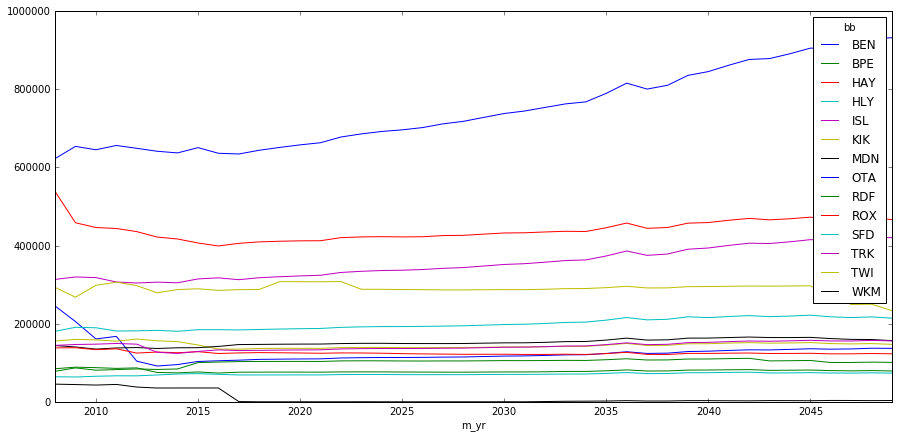

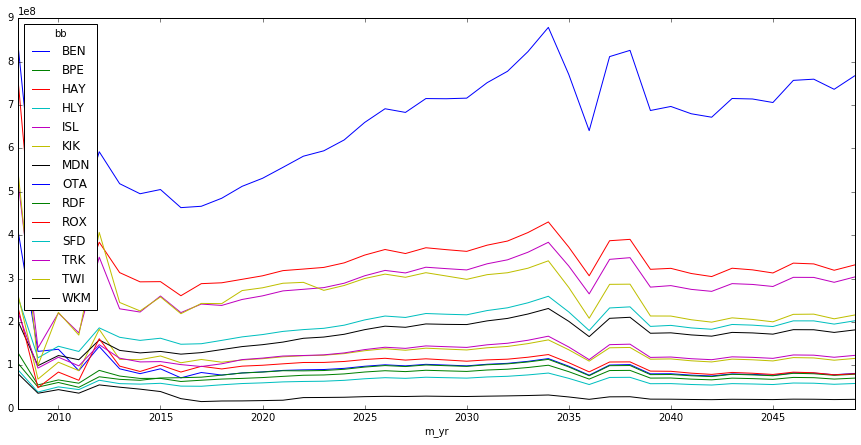

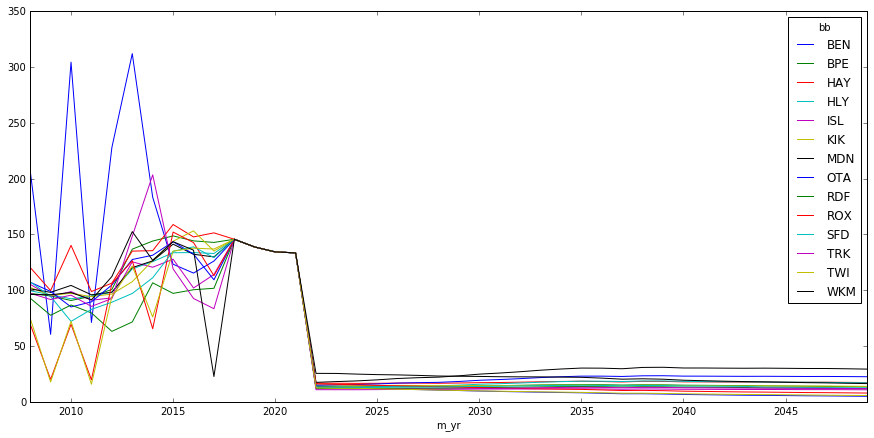

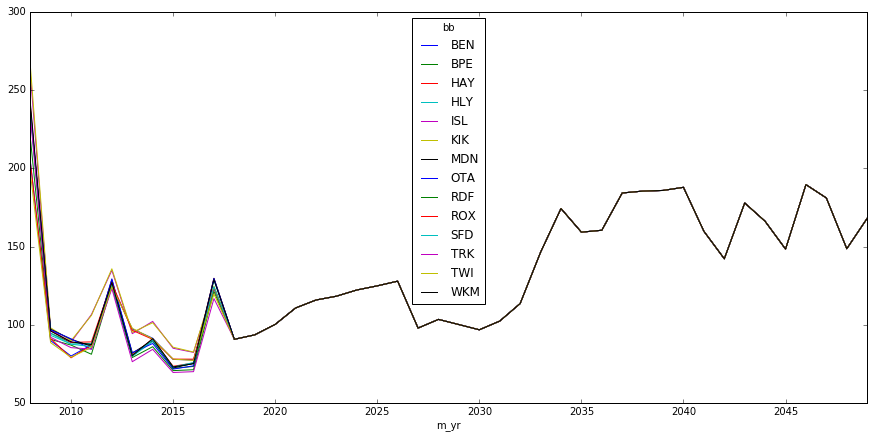

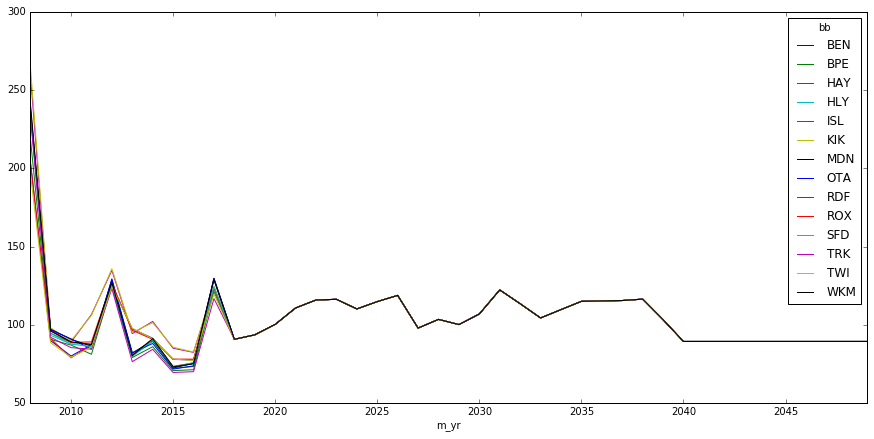

In [41]:
#Other - transformed input data
tp_rev.to_csv(out_fn+"tp_revenue.csv")

# Check a plot of the data
fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_q'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['exp_all'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_i'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_pg'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_rcpd.groupby(['m_yr','bb']).mean()['pk_pg'].unstack().plot(ax=ax)